# Marvel API Data Collection
Este notebook faz uso da **API da Marvel** para buscar dados sobre séries e personagens do universo Marvel. As informações são convertidas em **DataFrames do pandas** para facilitar a análise e são analisadas utilizando MatPlotLib.


### O que é uma Série na Marvel?

Uma **série** na Marvel é um conjunto de quadrinhos que compartilham um título e um volume específicos. As edições de uma série são organizadas de forma sequencial, facilitando o acompanhamento das histórias e dos personagens.

A Marvel utiliza o **ano de publicação original** como o número do volume. Assim, uma nova série com um título semelhante, mas em um ano diferente, pode ser considerada um novo volume, permitindo aos leitores identificar facilmente as edições que desejam ler.

Neste projeto, utilizamos informações sobre séries disponibilizadas pela Marvel API para analisar dados relacionados aos personagens, como a duração das séries, a frequência de aparições e a popularidade ao longo do tempo. Essas análises são realizadas através de visualizações que ajudam a entender melhor a dinâmica das histórias da Marvel.



## Dependências
Antes de executar o código, certifique-se de que você tenha as bibliotecas necessárias instaladas. Leia os arquivo requirements.txt

In [6]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import hashlib
import json
import ollama
import keys
from typing import List, Dict, Any
from requests.exceptions import Timeout, ConnectionError

# Explicação:
# - pandas: para manipulação e análise de dados.
# - matplotlib.pyplot: para visualização de dados.
# - requests: para fazer requisições HTTP.
# - time: para manipulação de tempo e delay em requisições.
# - hashlib: para criar hashes MD5.
# - json: para manipulação de respostas da API em formato JSON.
# - ollama: para utilização de GenAi.
# - keys: arquivo local para acessar as chaves publicas/privadas
# - typing: para anotações de tipos, facilitando a leitura e manutenção do código.
# - requests.exceptions: para tratamento de exceções específicas ao fazer requisições.


## Criação da Classe Marvel

Classe utilizada para adquirir os dados disponíveis na MarvelAPI e manipulá-los

In [7]:

class Marvel:
    """
Classe responsável por interagir com a API da Marvel e realizar operações com séries e personagens.

Atributos:
----------
public_key : str
    A chave pública fornecida pela Marvel.
private_key : str
    A chave privada fornecida pela Marvel.

Métodos:
--------
get_series(character_id: str) -> list:
    Faz requisições à API para obter todas as séries associadas a um personagem.
series_to_dataframe(series_list: list) -> pd.DataFrame:
    Converte uma lista de séries em um DataFrame do pandas.
characters_to_dataframe(series_list: list) -> pd.DataFrame:
    Converte uma lista de personagens (obtidos das séries) em um DataFrame com a contagem de recorrência.
    """



    def __init__(self, public_key: str, private_key: str):
        """
        Inicializa a API Marvel com as chaves públicas e privadas.
        
        :param public_key: A chave pública da API Marvel.
        :param private_key: A chave privada da API Marvel.
        """
        self.public_key = public_key
        self.private_key = private_key
        self.base_url = "http://gateway.marvel.com/v1/public/"
        self.ts = str(time.time())  # Timestamp único para a autenticação
        self.hash = self._create_hash()  # Hash de autenticação
    
    def _create_hash(self) -> str:
        """
        Cria o hash md5 necessário para autenticação.
        
        :return: O hash md5 gerado.
        """
        hash_input = self.ts + self.private_key + self.public_key
        return hashlib.md5(hash_input.encode()).hexdigest()
    
    def get_series(self, character_id: str, limit: int = 70, max_iterations: int = 15, retries: int = 10) -> List[Dict[str, Any]]:
        """
        Obtém as séries da Marvel para um personagem específico.
        
        :param character_id: O ID do personagem para buscar as séries.
        :param limit: O limite de resultados por requisição (máximo de 70).
        :param max_iterations: Número máximo de iterações para evitar loops infinitos.
        :param retries: Número de tentativas de reenvio em caso de falha.
        :return: Uma lista de dicionários contendo as séries da Marvel.
        """
        all_series: List[Dict[str, Any]] = []
        offset = 0
        iterations = 0
        
        while iterations < max_iterations:
            params = {
                "ts": self.ts,
                "apikey": self.public_key,
                "hash": self.hash,
                "characters": character_id,
                "limit": limit,
                "offset": offset
            }

            for attempt in range(retries):
                try:
                    response = requests.get(f"{self.base_url}series", params=params, timeout=10, verify=False)
                    response.raise_for_status()  # Levanta um erro para status codes 4xx/5xx
                    data: Dict[str, Any] = response.json()
                    all_series.extend(data['data']['results'])
                    
                    # Verifica se não há mais séries
                    if len(data['data']['results']) < limit:
                        return all_series

                    offset += limit
                    iterations += 1
                    time.sleep(2)  # Evita sobrecarregar o servidor com muitas requisições rápidas
                    break  # Sai do loop de tentativas se a requisição for bem-sucedida
                except (Timeout, ConnectionError) as e:
                    print(f"Tentativa {attempt+1}/{retries} falhou devido a {e}. Tentando novamente...")
                    time.sleep(2 ** attempt)  # Backoff exponencial
                except requests.exceptions.HTTPError as http_err:
                    print(f"Erro HTTP: {http_err}")
                    return all_series  # Sai da função se houver erro HTTP
            else:
                print(f"Falha após {retries} tentativas.")
                break  # Sai do loop principal se o número de tentativas for excedido
        
        return all_series
    
    def save_to_file(self, data: List[Dict[str, Any]], filename: str = "marvel_data.txt") -> None:
        """
        Salva os dados em um arquivo JSON.
        
        :param data: A lista de dicionários a ser salva no arquivo.
        :param filename: O nome do arquivo onde os dados serão salvos.
        """
        with open(filename, "w") as outfile:
            json.dump(data, outfile, indent=4)
        print(f"Dados salvos em '{filename}'")


    def series_to_dataframe(self, all_series: List[Dict[str, Any]], filename: str = "character_series_summary.csv") -> pd.DataFrame:
            """
            Converte as informações das séries em um DataFrame e salva como CSV.
            
            :param all_series: A lista de dicionários com as séries obtidas da API.
            :param filename: O nome do arquivo CSV onde os dados serão salvos.
            :return: Um DataFrame com os dados processados das séries.
            """
            series_data = []
            
            for series in all_series:
                series_info = {
                    'title': series['title'],
                    'start_year': series['startYear'],
                    'end_year': series['endYear'],

                }
                series_data.append(series_info)
            
            df = pd.DataFrame(series_data)
            df['end_year'] = df['end_year'].replace(2099, 2024)  # Datas futuras mudadas para 2024
            df['start_year'] = df['start_year'].replace(0, 2000)  # Datas 0000 mudadas para 2000

            df['duration'] = df['end_year'] - df['start_year']
            df.loc[df['duration'] > 2000, 'duration'] = 0  # Datas com valor 0000 alteradas para 0
            df.loc[df['duration'] < 0, 'duration'] = 0  # Substituir durações inválidas por 0

            # Salvar o DataFrame em um arquivo CSV
            df.to_csv(filename, index=False)
            print(f"DataFrame salvo em '{filename}'")
            
            return df
        
    def characters_to_dataframe(self, all_series: List[Dict[str, Any]], top_n: int = 12, filename: str = "top_characters.csv") -> pd.DataFrame:
        """
        Converte as informações dos personagens em um DataFrame com a contagem de aparições, e salva como CSV.
        
        :param all_series: A lista de dicionários com as séries obtidas da API.
        :param top_n: O número de personagens mais recorrentes a exibir (padrão 12).
        :param filename: O nome do arquivo CSV onde os dados serão salvos.
        :return: Um DataFrame com os personagens mais recorrentes.
        """
        all_characters = []
        
        for series in all_series:
            characters = [char['name'] for char in series['characters']['items']]
            all_characters.extend(characters)  # Adiciona todos os personagens na lista

        # Criar um DataFrame com a contagem de cada personagem
        characters_df = pd.DataFrame(all_characters, columns=['Character'])
        character_counts = characters_df['Character'].value_counts()

        # Transformar a contagem em um DataFrame
        character_counts_df = character_counts.reset_index()
        character_counts_df.columns = ['Character', 'Count']

        # Remove o primeiro colocado (normalmente o protagonista)
        character_counts_df = character_counts_df.drop(index=0)

        # Exibir os personagens mais recorrentes
        top_characters = character_counts_df.head(top_n)

        # Salvar o DataFrame em um arquivo CSV
        top_characters.to_csv(filename, index=False)
        print(f"DataFrame dos {top_n} personagens mais recorrentes salvo em '{filename}'")
        
        return top_characters


## Inicialização da API e coleta de dados
Aqui criamos uma instância da API Marvel, utilizando as chaves públicas e privadas fornecidas, e obtemos informações sobre as séries e personagens.


In [32]:
public_key = keys.my_public_key
private_key = keys.my_private_key


marvel = Marvel(public_key,private_key)


# Alguns exemplos de Marvel Character IDs:
# 1009610 - Spider-Man
# 1009368 - Iron Man
# 1009220 - Captain America
# 1009664 - Thor
# 1009351 - Hulk
# 1009189 - Black Widow
# 1009718 - Wolverine
# 1009187 - Black Panther
# 1009268 - Deadpool
# 1010841 - Doctor Strange
# 1009313 - Gambit
# 1009155 - Ant-Man
# 1009562 - Scarlet Witch
# 1009697 - Vision
# 1009652 - Thanos
# 1010763 - Gamora
# 1010733 - Star-Lord
# 1010735 - Drax
# 1010744 - Rocket Raccoon
# 1009338 - Hawkeye
# 1009407 - Loki
# 1009592 - Silver Surfer

#Personagem1
character_id = 1009268  # DeadPool 

#Personagem1
character_id_2 = 1009313 # Gambit


all_series_1 = marvel.get_series(character_id)
all_series_2 = marvel.get_series(character_id_2)


df = marvel.series_to_dataframe(all_series_1)
df2 = marvel.series_to_dataframe(all_series_2)


top_characters_1 = marvel.characters_to_dataframe(all_series_1)

print ("Operação bem sucedida")

DataFrame salvo em 'character_series_summary.csv'
DataFrame salvo em 'character_series_summary.csv'
DataFrame dos 12 personagens mais recorrentes salvo em 'top_characters.csv'
Operação bem sucedida


## GEN AI
Aqui há uma simples implementação do Ollama (utlizando o modelo PHI3), que será usado para descrever a utilidade de cada gráfico (Informações utilizadas na descrição dos tipos gráfico, logo abaixo)

In [5]:
response = ollama.chat(model='phi3', messages=[
  {
    'role': 'user',
    'content': (
        'Estou criando gráficos com dados que retirei da MARVEL API. '
        'Tenho um gráfico mostrando o número de séries lançadas onde aquele herói esteve '
        'presente em intervalos de 5 anos.\n\n'
        'Ou seja, de quantas séries aquele personagem participou em intervalos de 5 anos '
        '(1966, 1960, 1970).'
        'O que esse gráfico me permite inferir?'
      ),
  },
])
print(response['message']['content'])

Usando dados da MARVEL API para criar um gráfico mostrando o número de séries onde os heróis participaram em intervalos de cinco anos pode oferecer insights valiosos sobre várias questões. Aqui estão algumries implicações que você poderia extrair:

1. Popularidade ao longo do tempo dos personagens - Se determinados personagens têm uma tendência crescente ou decrescente em participações de séries, isso pode indicar mudanças na popularidade do personagem com o público e também refletir como a MARVEL evoluiu sua marca para atender às preferências dos fãs ao longo do tempo.

2 - Representação diversificada ou homogeneização no Universo Marvel: Se certos anos têm uma maior variedade de heróis com participações em séries, isso pode indicar que a MARVEL está buscando por mais inclusão e representação cultural durante esse período. Por outro lado, se apenas alguns personagens ou grupos culturais dominam esses períodos, eles podem estar refletindo questões de diversidade dentro da marca Marvel 

## Criação de Gráficos para a Análise de Dados
Aqui começamos a plotar os gráficos para posteriormente poder analisá-los

**OBS: o trecho "Utilidade" de cada gráfico foi gerado pela GEN AI presente acima**

## 1. Gráfico: Média de Duração das Séries em Intervalos de 3 Anos
**Utilidade:**  
Este gráfico nos permite visualizar a evolução da duração média das séries em que o personagem participou ao longo dos anos. Ele é útil para identificar se as séries estão ficando mais longas ou curtas com o passar do tempo, revelando tendências de produção da Marvel para este personagem. Também nos ajuda a identificar possíveis mudanças de estratégia em relação à duração das séries.



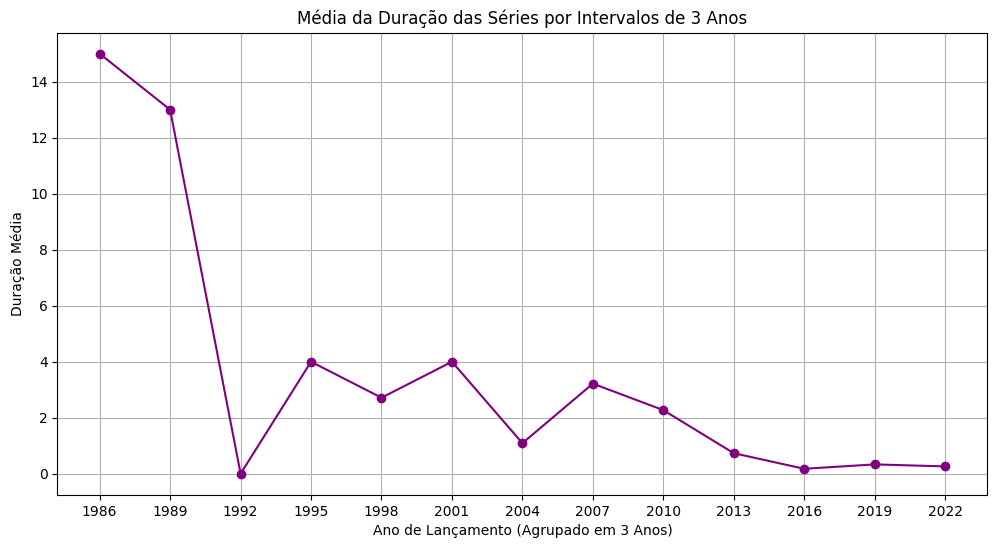

In [38]:
# Agrupar os anos de 3 em 3
df['year_group'] = (df['start_year'] // 3) * 3
average_duration_grouped = df.groupby('year_group')['duration'].mean().reset_index()

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(average_duration_grouped['year_group'], average_duration_grouped['duration'], marker='o', linestyle='-', color='purple')
plt.title('Média da Duração das Séries por Intervalos de 3 Anos')
plt.xlabel('Ano de Lançamento (Agrupado em 3 Anos)')
plt.ylabel('Duração Média')
plt.grid(True)
plt.xticks(average_duration_grouped['year_group'])
plt.show()


## 2. Gráfico: Percentual de Duração das Séries
**Utilidade:**  
Este gráfico mostra a distribuição percentual das durações das séries nas quais o personagem participou. Ele é útil para determinar se o personagem está mais presente em séries de curta, média ou longa duração, fornecendo insights sobre o tipo de histórias em que o personagem costuma aparecer. Isso também ajuda a entender como o público pode estar reagindo às séries em termos de longevidade.


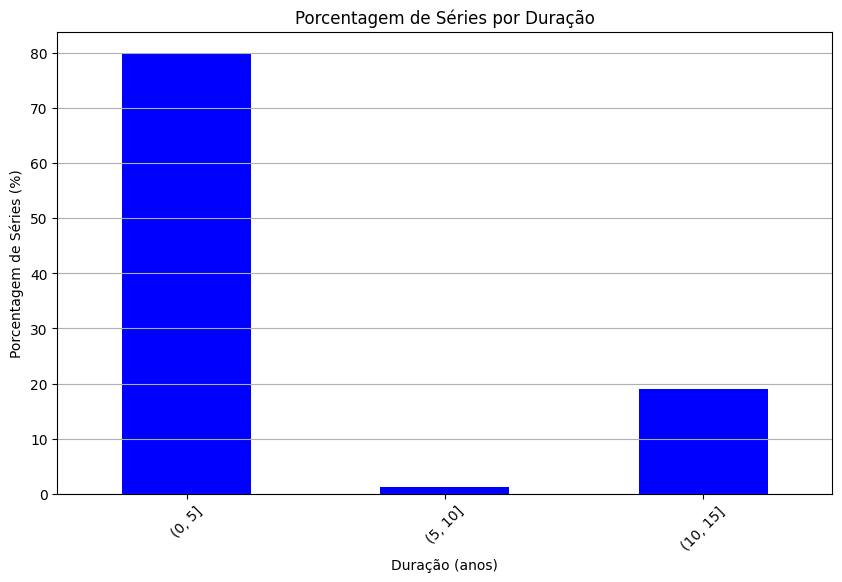

In [39]:
bins = range(0, df['duration'].max() + 5, 5)  # Intervalos de 5 anos
df['duration_group'] = pd.cut(df['duration'], bins)

# Contar o número de séries em cada grupo de duração
duration_counts = df['duration_group'].value_counts().sort_index()

# Calcular a porcentagem
duration_percentage = (duration_counts / duration_counts.sum()) * 100

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
duration_percentage.plot(kind='bar', color='blue')

# Adicionar título e rótulos
plt.title('Porcentagem de Séries por Duração')
plt.xlabel('Duração (anos)')
plt.ylabel('Porcentagem de Séries (%)')

# Exibir o gráfico
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 3. Gráfico: Número de Séries Lançadas em Intervalos de 5 Anos
**Utilidade:**  
Este gráfico nos permite acompanhar a evolução da popularidade do personagem ao longo do tempo, com base na quantidade de séries lançadas em intervalos de 5 anos. Ele é útil para identificar os picos e quedas na popularidade do personagem e pode ser correlacionado com eventos importantes na Marvel, como grandes lançamentos de filmes ou arcos narrativos importantes nas HQs.


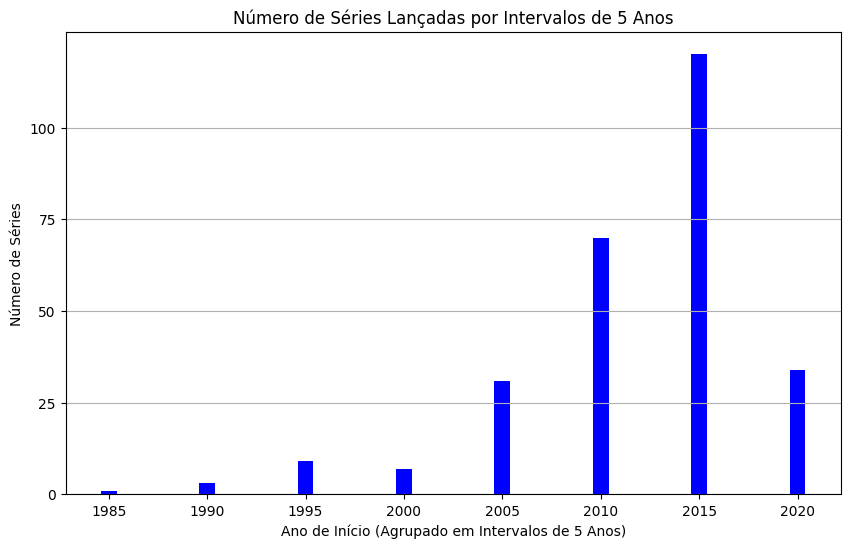

In [40]:
df['year_group'] = (df['start_year'] // 5) * 5  # Cria um grupo de 5 em 5 anos
series_count = df.groupby('year_group').size().reset_index(name='number_of_series')

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.bar(series_count['year_group'], series_count['number_of_series'], color='blue')

# Adicionar título e rótulos
plt.title('Número de Séries Lançadas por Intervalos de 5 Anos')
plt.xlabel('Ano de Início (Agrupado em Intervalos de 5 Anos)')
plt.ylabel('Número de Séries')

# Exibir o gráfico
plt.xticks(series_count['year_group'])  # Para garantir que todos os grupos sejam exibidos
plt.yticks(range(0, series_count['number_of_series'].max() + 1, 25))
plt.grid(axis='y')
plt.show()

## 4. Gráfico: Personagens Mais Recorrentes nas Mesmas Histórias
**Utilidade:**  
Este gráfico nos ajuda a identificar os personagens que mais aparecem junto com o herói em questão. Ele é útil para entender com quais outros personagens o herói tem mais interações, o que pode sugerir colaborações frequentes ou rivalidades. Além disso, nos dá uma visão sobre o contexto narrativo em que o herói está inserido.

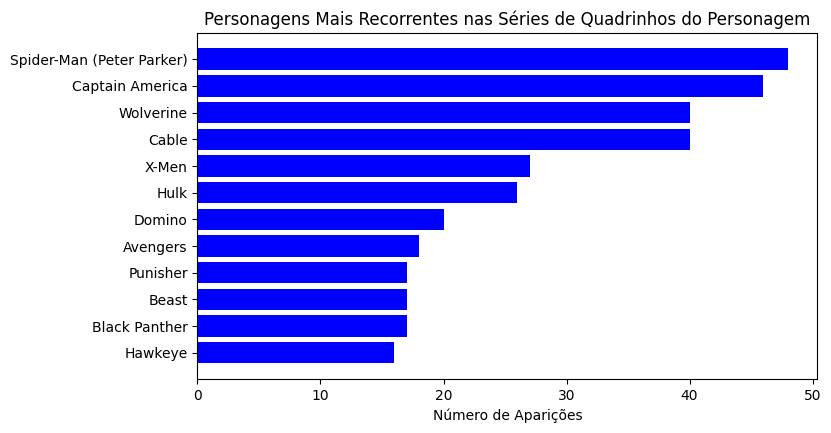

In [36]:
# Plotar
plt.figure(figsize=(8, 4.5))
plt.barh(top_characters_1['Character'], top_characters_1['Count'], color='blue')
plt.xlabel('Número de Aparições')
plt.title('Personagens Mais Recorrentes nas Séries de Quadrinhos do Personagem')
plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar o mais recorrente em cima
plt.show()

## 5. Gráfico: Comparação de Popularidade entre Dois Personagens
**Utilidade:**  
Este gráfico nos permite comparar a popularidade de dois personagens ao longo do tempo, observando o número de séries em que cada um esteve presente. Ele é útil para entender a dinâmica entre os dois personagens e como a popularidade de cada um evoluiu. Além disso, possibilita detectar se houve um período em que a popularidade de um cresceu às custas do outro.

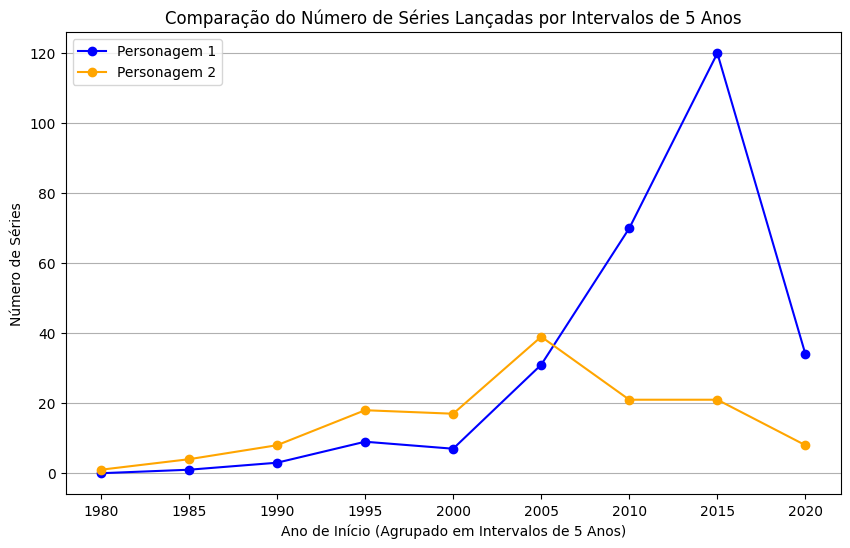

In [37]:
# Adicionar a coluna 'year_group' em ambos
df['year_group'] = (df['start_year'] // 5) * 5  # Agrupar por intervalos de 5 anos
df2['year_group'] = (df2['start_year'] // 5) * 5  # Agrupar por intervalos de 5 anos

# Contagem de séries por grupos de anos
series_count1 = df.groupby('year_group').size().reset_index(name='number_of_series_1')
series_count2 = df2.groupby('year_group').size().reset_index(name='number_of_series_2')

# Mesclar os dois dataframes com base no 'year_group'
merged_df = pd.merge(series_count1, series_count2, on='year_group', how='outer').fillna(0)

# Criar o gráfico de linhas
plt.figure(figsize=(10, 6))

# Plotar as linhas dos dois personagens
plt.plot(merged_df['year_group'], merged_df['number_of_series_1'], label='Personagem 1', marker='o', color='blue')
plt.plot(merged_df['year_group'], merged_df['number_of_series_2'], label='Personagem 2', marker='o', color='orange')

# Adicionar título e rótulos
plt.title('Comparação do Número de Séries Lançadas por Intervalos de 5 Anos')
plt.xlabel('Ano de Início (Agrupado em Intervalos de 5 Anos)')
plt.ylabel('Número de Séries')

# Exibir as legendas e ajustes
plt.xticks(merged_df['year_group'])  # Para garantir que todos os grupos sejam exibidos
plt.grid(axis='y')
plt.legend()

# Exibir o gráfico
plt.show()


# Conclusão
Cada gráfico fornece informações valiosas sobre o personagem em análise, desde a sua popularidade até a natureza das séries em que ele participou. Esses insights podem ser utilizados para entender o comportamento do personagem dentro do universo Marvel, prever tendências futuras e realizar comparações entre personagens.